### Import all necessary libraries

In [ ]:
#import tensorflow as tf
#print(tf.__version__)
#2.13.0

In [ ]:
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.15.0
#!pip install TA-Lib


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.base import BaseEstimator
import time
import yfinance as yf


import time
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, LayerNormalization
from tensorflow.keras.regularizers import l2

#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import mstats
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Evaluation Metrics
- MAE, RMSE, MASE

In [2]:
    
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - MASE value.
    """
    # Ensure data is in NumPy array format
    y_test, test_predictions = np.array(y_true), np.array(y_pred)

    # Compute naive forecast (previous value as next step)
    naive_forecast = np.roll(y_test, shift=1)
    naive_forecast[0] = y_test[0]  # Keep first value unchanged to avoid shifting issues

    # Compute MAE for both model and naive forecast
    mae = mean_absolute_error(y_test, test_predictions)
    naive_mae = mean_absolute_error(y_test, naive_forecast)

    # Handle division by zero (if naive_mae is very small)
    epsilon = 1e-8  # Small constant to avoid division errors
    mase = mae / (naive_mae + epsilon)
    
    return mase


def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    epsilon=1e-8
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    mase_original = mean_absolute_scaled_error(y_true_original , y_pred_original) 
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original, mase_original

### Functions from Creating time series data, Data splitting, Data scaling, Hyp-params optimization, Full-model Training

In [3]:
# =============================================================================
# Function 1: Create Multi-Feature Time-Series Data (Target = LogReturn)
# =============================================================================
def create_time_series_data(data, look_back=10):
    """
    Converts a 2D NumPy array of shape (num_samples, num_features)
    into time-series arrays for LSTM.
    
    Here the target (y) is set to the value of the first column (LogReturn)
    at time (i + look_back).
    
    Returns:
      X: Array of shape (num_samples - look_back, look_back, num_features)
      y: Array of shape (num_samples - look_back,) – the target log returns.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :])
        # Target is now the next day's LogReturn (assumed to be column 0)
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# =============================================================================
# Function 2: Split Data & Compute Features (LogReturn and SMAs)
# =============================================================================
def split_data(data, sma_windows, look_back, train_start, train_end, test_start, test_end):
    """
    1. Computes log returns.
    2. Computes SMAs for each window in sma_windows.
    3. Adds seasonality features (month, quarter, week of the year, and day of week).
    4. Drops NaN values.
    5. Splits data into train and test sets based on lengths.
    6. Creates time-series arrays (X, y) where y is the next day's log return.
    
    Returns:
      X_train, X_test, y_train, y_test, feature_cols
    """
    data = data.copy()
    # Compute log returns
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Compute SMAs for each window size
    for w in sma_windows:
        data[f'SMA_{w}'] = data['Close'].rolling(window=w).mean()
    
    # Compute seasonality features
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek
    
    data.dropna(inplace=True)
    
    train_size = int(len(data) * 0.70)
    train_data, test_data = data[:train_size], data[train_size:]
    
    print(train_data.shape)
    print(test_data.shape)
    
    # Feature order: LogReturn, SMAs, Seasonality, Close
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close']
    
    X_train, y_train = create_time_series_data(train_data[feature_cols].values, look_back)
    X_test,  y_test  = create_time_series_data(test_data[feature_cols].values, look_back)
    
    return X_train, X_test, y_train, y_test, feature_cols


# =============================================================================

In [4]:
# =============================================================================
# Function 3: Scale the Data
# =============================================================================
def scale_data(X_train, X_test, y_train, y_test):
    """
    Scales the features and target.
    The feature scaler is applied to the flattened feature set and then reshaped back.
    """
    feature_scaler = MinMaxScaler()
    target_scaler  = MinMaxScaler()
    
    n_train, lb, nf = X_train.shape
    X_train_2d = X_train.reshape(n_train * lb, nf)
    n_test, lb_test, nf_test = X_test.shape
    X_test_2d = X_test.reshape(n_test * lb_test, nf_test)
    
    X_train_scaled_2d = feature_scaler.fit_transform(X_train_2d)
    X_test_scaled_2d  = feature_scaler.transform(X_test_2d)
    
    X_train_scaled = X_train_scaled_2d.reshape(n_train, lb, nf)
    X_test_scaled  = X_test_scaled_2d.reshape(n_test, lb_test, nf_test)
    
    # Scale target (log returns)
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled  = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# =============================================================================
# Function 4: Build LSTM Model
# =============================================================================
def build_lstm_model(units, dropout, learning_rate, look_back, num_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='relu', return_sequences=True), 
                            input_shape=(look_back, num_features)))
    model.add(LayerNormalization()) 
    model.add(Bidirectional(LSTM(units // 2, activation='relu'
                                 )))
    model.add(Dropout(dropout))  
    model.add(Dense(1))  
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    
    return model

# =============================================================================
# Function 5: LSTMRegressor (Sklearn Wrapper)
# =============================================================================

class LSTMRegressor(BaseEstimator):
    def __init__(self, units=64, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32, look_back=10, num_features=5, patience=5):
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.look_back = look_back
        self.num_features = num_features
        self.patience = patience  
        self.model_ = None
        
    def fit(self, X, y):
        self.model_ = build_lstm_model(self.units, self.dropout, self.learning_rate, self.look_back, self.num_features)
        #self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        # Early Stopping Callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        
        # Train the model with Early Stopping and a fixed validation split (no TimeSeriesSplit here)
        self.model_.fit(X, y, 
                        epochs=self.epochs, 
                        batch_size=self.batch_size, 
                        verbose=0, 
                        validation_split=0.2,  # Simple 20% validation split
                        callbacks=[early_stopping])
        return self
    
    def predict(self, X):
        return self.model_.predict(X, verbose=0)

# =============================================================================
# Function 6: Bayesian Hyperparameter Optimization for LSTMRegressor
# =============================================================================
def model_training(X_train_scaled, y_train_scaled, look_back, num_features):
    
    param_space = {
    'units': Integer(32, 128),
    'dropout': Real(0.3, 0.7),
    'learning_rate': Real(0.001, 0.03, prior='log-uniform'),
        
    }
    
    estimator = LSTMRegressor(look_back=look_back, num_features=num_features)
    bayes_search = BayesSearchCV(estimator, param_space, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
    
    y_train_scaled_2d = y_train_scaled.reshape(-1, 1)
    bayes_search.fit(X_train_scaled, y_train_scaled_2d)
    print("Best Model Parameters:", bayes_search.best_params_)
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    return best_model, best_params

# =============================================================================
# Function 7: Train Final Model on Full Dataset
# =============================================================================
def train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features):
    X_full, _, y_full, _, _ = split_data(data, sma_windows, look_back, "2000-01-01", "2021-12-31", None, None)

    n_full, lb, nf = X_full.shape
    X_full_2d = X_full.reshape(n_full * lb, nf)
    X_full_scaled_2d = feature_scaler.transform(X_full_2d)
    X_full_scaled = X_full_scaled_2d.reshape(n_full, lb, nf)

    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))

    # Step 1: **Train Model on Full Data First (Reduce Epochs to 10)**
    final_model = LSTMRegressor(
        units=best_params['units'],
        dropout=best_params['dropout'],
        learning_rate=best_params['learning_rate'],
        epochs=20,  # 
        batch_size=32,
        look_back=look_back,
        num_features=num_features
    )

    #print(" Training Model on Full Data (20 epochs) Before Teacher Forcing...")
    final_model.fit(X_full_scaled, y_full_scaled)  
    
    return final_model


# =============================================================================

### Method for future days forecasting

In [5]:
def forecast_future_multi_step(
    data,
    model,
    feature_scaler,
    target_scaler,
    sma_windows,
    look_back,
    start_date="2022-01-01",
    end_date="2022-12-31"
):

    data = data.copy()
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1)) if 'LogReturn' not in data else data['LogReturn']
    
    for w in sma_windows:
        col = f'SMA_{w}'
        if col not in data:
            data[col] = data['Close'].rolling(window=w).mean()

    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek
    data.dropna(inplace=True)
    
    data.index = pd.to_datetime(data.index)
    forecast_df = data[data.index < start_date].copy()

    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close']
    predictions = []

    q01, q99 = data['LogReturn'].quantile([0.01, 0.99])

    for i, date in enumerate(future_dates):
        window = forecast_df.iloc[-look_back:]
        if len(window) < look_back or window.isna().values.any():
            break

        X_scaled = feature_scaler.transform(window[feature_cols].values).reshape(1, look_back, -1)
        pred_scaled = model.predict(X_scaled)[0][0]
        pred_log_return = target_scaler.inverse_transform([[pred_scaled]])[0][0]

        #if np.isnan(pred_log_return):
        #    pred_log_return = 0.0

        #if abs(pred_log_return) > 0.06:
        #    smooth = 0.5
        #    extreme = q99 if pred_log_return > 0 else q01
        #    pred_log_return = smooth * extreme + (1 - smooth) * window['LogReturn'].iloc[-1]

        pred_close = forecast_df['Close'].iloc[-1] * np.exp(pred_log_return)

        new_row_data = {
            'LogReturn': pred_log_return,
            'Close': pred_close,
            'Month': date.month,
            'Quarter': date.quarter,
            'WeekOfYear': date.isocalendar()[1],
            'DayOfWeek': date.weekday(),
        }

        # Efficient SMA calculation only for the new row
        for w in sma_windows:
            last_closes = forecast_df['Close'].iloc[-(w-1):].tolist()  # Last w-1 closes
            last_closes.append(pred_close)  # Include the new forecasted close
            new_row_data[f'SMA_{w}'] = np.mean(last_closes)

        # Append the new row
        new_row = pd.DataFrame([new_row_data], index=[date])
        forecast_df = pd.concat([forecast_df, new_row])

        predictions.append((date, pred_log_return))

    pred_df = pd.DataFrame(predictions, columns=['Date', 'Forecasted_Log_Return']).set_index('Date')
    return pred_df, forecast_df


### Workflow which executes all the above methods

In [6]:
# =============================================================================
# Function 9: Main Function to Run the Pipeline (Now for LogReturn Forecasting)
# =============================================================================
def main(data):
    look_back = 10
    sma_windows = [5, 10, 30]
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end   = "2015-01-01", "2022-01-01"
    
    # 9.1) Split data and compute features.
    X_train, X_test, y_train, y_test, feature_cols = split_data(data, sma_windows, look_back,
                                                                 train_start, train_end,
                                                                 test_start, test_end)
    # 9.2) Scale the data.
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)
    _, _, num_features = X_train_scaled.shape
    
    start_time = time.time()  
    # 9.3) Bayesian hyperparameter tuning.
    best_model, best_params = model_training(X_train_scaled, y_train_scaled, look_back, num_features)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
     # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    # Evaluate Train-Test Performance
    train_rmse, train_mae, train_mase = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae, test_mase = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MASE : {train_mase:.4f} ")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MASE: {test_mase:.4f} ")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse,
                    "mase" : train_mase
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse,
                    "mase" : test_mase
                },
                "time":computaton_time
                
        }
    
    # 9.4) Train the final model on the full dataset.
    final_model = train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features)
    
    # 9.5) Forecast future log returns (and compute forecasted closes).
    pred_df, forecast_df = forecast_future_multi_step(data, final_model, feature_scaler, target_scaler,
                                                       sma_windows, look_back,
                                                       start_date="2022-01-01", end_date="2022-12-31")
    print("\n=== Future LogReturn Predictions ===")
    print(pred_df)
    
    #print("\n=== Future Full Predictions ===")
    #print(forecast_df)
    
    return final_model, pred_df, forecast_df, model_metrics

# =============================================================================

### Grouping forecast into monthly and weekly horizons

In [7]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [8]:
def plot_forecasted_returns(df_forecast):
    """
    Plots the forecasted log returns over time.
    
    Parameters:
    df_forecast (pd.DataFrame): DataFrame containing 'Date' and 'Forecasted_Log_Return' columns.
    """
    #print(df_forecast.columns)
    #print(df_forecast.index)
    # Ensure Date column is datetime type
    # Ensure index is datetime type
    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Plot the forecasted returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast["Forecasted_Log_Return"], color='orange', linestyle='-', label="Forecasted Returns")
    
    plt.title("Forecasted Log Returns for 2022")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Log Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

### Method to trigger the above worflow with input tickers and data loading method

In [9]:
# =============================================================================
# Workflow Function for Multiple Tickers
# =============================================================================

def run_workflow(tickers):
    """
    Runs the full forecasting workflow for multiple stock tickers.
    
    For each ticker:
      1. Downloads historical data.
      2. Runs the full pipeline (via main(data)) to get forecasts.
      3. Groups forecasted returns/prices month-wise and week-wise for 2022.
      4. Stores the grouped forecasts in a results dictionary.
      
    Parameters:
      tickers: List of ticker symbols (strings).
      
    Returns:
      results: A dictionary keyed by ticker with grouped forecast results.
    """
    global results
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download historical data
        data = yf.download(ticker, start="2000-01-01", end="2021-12-31", auto_adjust=True)
        data.columns = data.columns.get_level_values(0)
        data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        
        data.index = pd.to_datetime(data.index)
        
        # Step 2: Run the full pipeline.  
        # Assume that main() returns (final_model, future_preds, full_forecast_df)
        final_model, future_preds, full_forecast_df, model_metrics = main(data)
               
        plot_forecasted_returns(future_preds)
        
        # Step 3: Group forecasted returns/prices month-wise and week-wise for 2022.
        # (Here, future_preds is assumed to be a DataFrame with a DateTime index.
        #  For example, it might have a column 'Forecasted_Close' or 'Forecasted_LogReturn'.)
        monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2022)
        
        # Step 4: Store results in the dictionary.
        results[ticker] = {
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
        
    return results
# List of tickers to process.
# Define tickers in batches
results = {}


Processing SMH...


[*********************100%***********************]  1 of 1 completed


(3779, 9)
(1621, 9)
Best Model Parameters: OrderedDict([('dropout', 0.4779330049204607), ('learning_rate', 0.022754356809600706), ('units', 42)])
Computation Time: 232.98 seconds
Train RMSE: 0.0230, Train MAE: 0.0160, Train MASE : 0.7004 
Test RMSE: 0.0185, Test MAE: 0.0132, Test MASE: 0.6893 
(3779, 9)
(1621, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000728
2022-01-04               0.000674
2022-01-05               0.000672
2022-01-06               0.000658
2022-01-07               0.000655
2022-01-10               0.000654
2022-01-11               0.000645
2022-01-12               0.000642
2022-01-13               0.000644
2022-01-14               0.000661
2022-01-17               0.000736
2022-01-18               0.000715
2022-01-19               0.000709
2022-01-20               0.000709
2022-01-21               0.000714
2022-01-24               0.000736
2022-01-25               0.000715
2

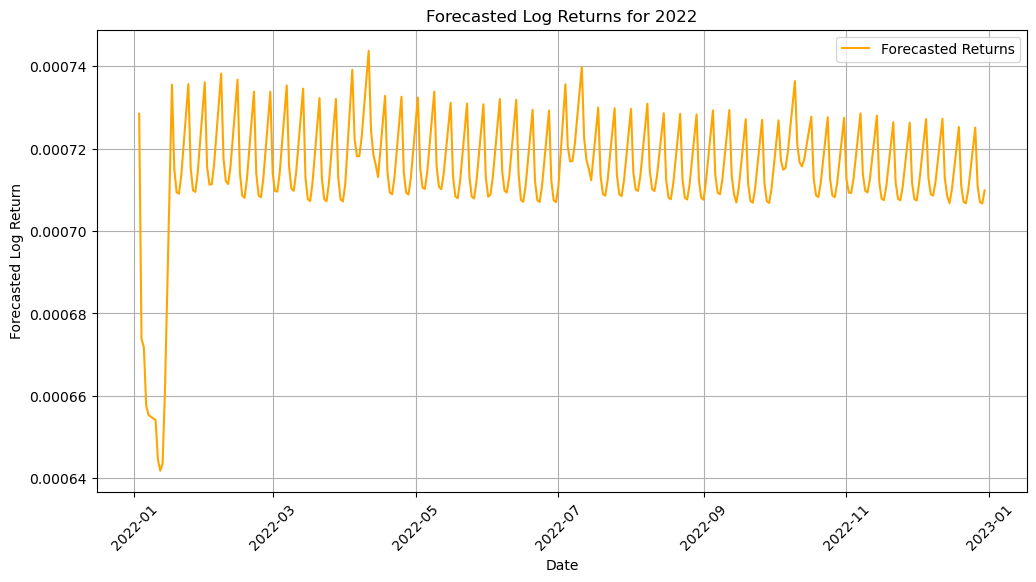

In [10]:
# Execute the workflow for multiple tickers.
tickers1 = ['SMH']
results = run_workflow(tickers1)

Processing SOXX...


[*********************100%***********************]  1 of 1 completed


(3584, 9)
(1537, 9)
Best Model Parameters: OrderedDict([('dropout', 0.4779330049204607), ('learning_rate', 0.022754356809600706), ('units', 42)])
Computation Time: 221.10 seconds
Train RMSE: 0.0208, Train MAE: 0.0150, Train MASE : 0.7010 
Test RMSE: 0.0186, Test MAE: 0.0130, Test MASE: 0.6713 
(3584, 9)
(1537, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.001089
2022-01-04               0.001082
2022-01-05               0.001083
2022-01-06               0.001083
2022-01-07               0.001084
2022-01-10               0.001085
2022-01-11               0.001083
2022-01-12               0.001082
2022-01-13               0.001083
2022-01-14               0.001084
2022-01-17               0.001088
2022-01-18               0.001085
2022-01-19               0.001085
2022-01-20               0.001085
2022-01-21               0.001086
2022-01-24               0.001088
2022-01-25               0.001085
2

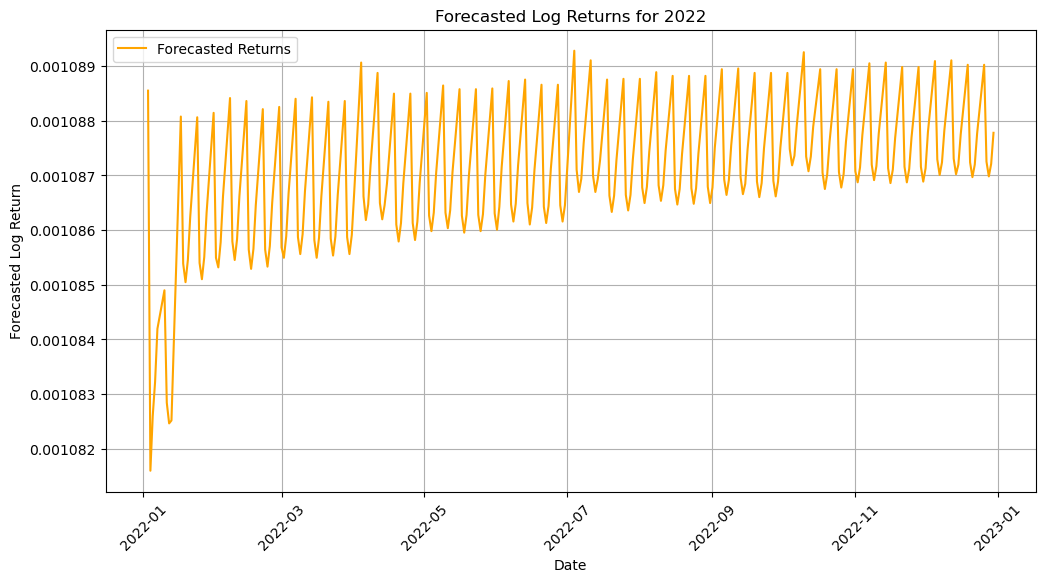

In [11]:
# Execute the workflow for multiple tickers.
tickers2 = ['SOXX']
results = run_workflow(tickers2)

Processing PSI...


[*********************100%***********************]  1 of 1 completed


(2891, 9)
(1240, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.024409731675583402), ('units', 48)])
Computation Time: 167.39 seconds
Train RMSE: 0.0175, Train MAE: 0.0130, Train MASE : 0.6964 
Test RMSE: 0.0207, Test MAE: 0.0146, Test MASE: 0.6728 
(2891, 9)
(1240, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000790
2022-01-04               0.000804
2022-01-05               0.000805
2022-01-06               0.000809
2022-01-07               0.000809
2022-01-10               0.000808
2022-01-11               0.000810
2022-01-12               0.000811
2022-01-13               0.000811
2022-01-14               0.000806
2022-01-17               0.000793
2022-01-18               0.000798
2022-01-19               0.000800
2022-01-20               0.000800
2022-01-21               0.000798
2022-01-24               0.000793
2022-01-25               0.000798
2

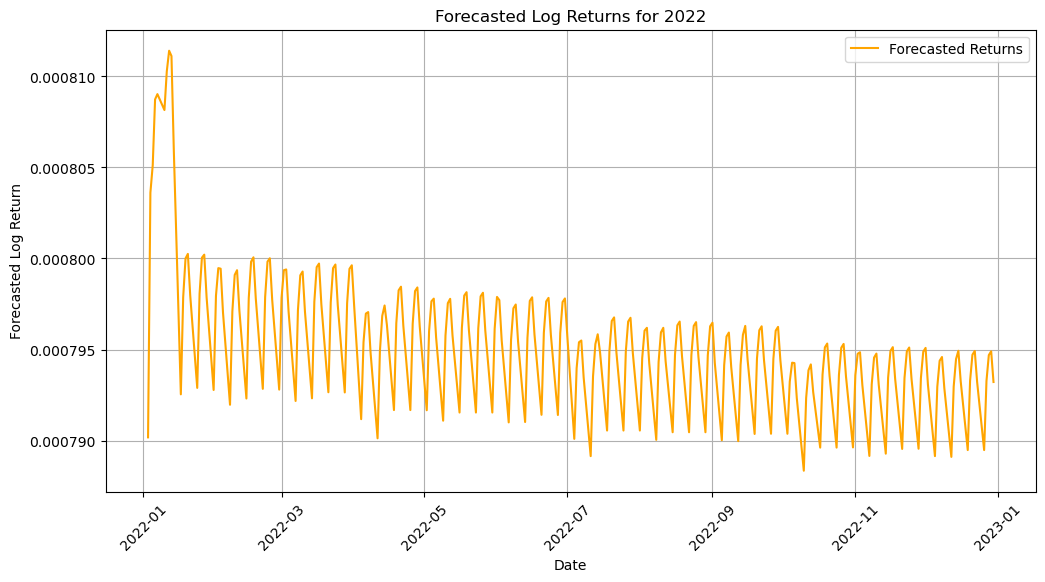

In [12]:
# Execute the workflow for multiple tickers.
tickers3 = ['PSI']
results = run_workflow(tickers3)

[*********************100%***********************]  1 of 1 completed

Processing XSD...
(2782, 9)
(1193, 9)


Best Model Parameters: OrderedDict([('dropout', 0.6349553422213137), ('learning_rate', 0.020172687965597087), ('units', 61)])
Computation Time: 191.59 seconds
Train RMSE: 0.0183, Train MAE: 0.0135, Train MASE : 0.7024 
Test RMSE: 0.0205, Test MAE: 0.0145, Test MASE: 0.6651 
(2782, 9)
(1193, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000361
2022-01-04               0.000361
2022-01-05               0.000361
2022-01-06               0.000361
2022-01-07               0.000361
2022-01-10               0.000361
2022-01-11               0.000362
2022-01-12               0.000362
2022-01-13               0.000362
2022-01-14               0.000362
2022-01-17               0.000362
2022-01-18               0.000362
2022-01-19               0.000362
2022-01-20               0.000362
2022-01-21               0.000362
2022-01-24               0.000362
2022-01-25               0.000362
2022-01-26           

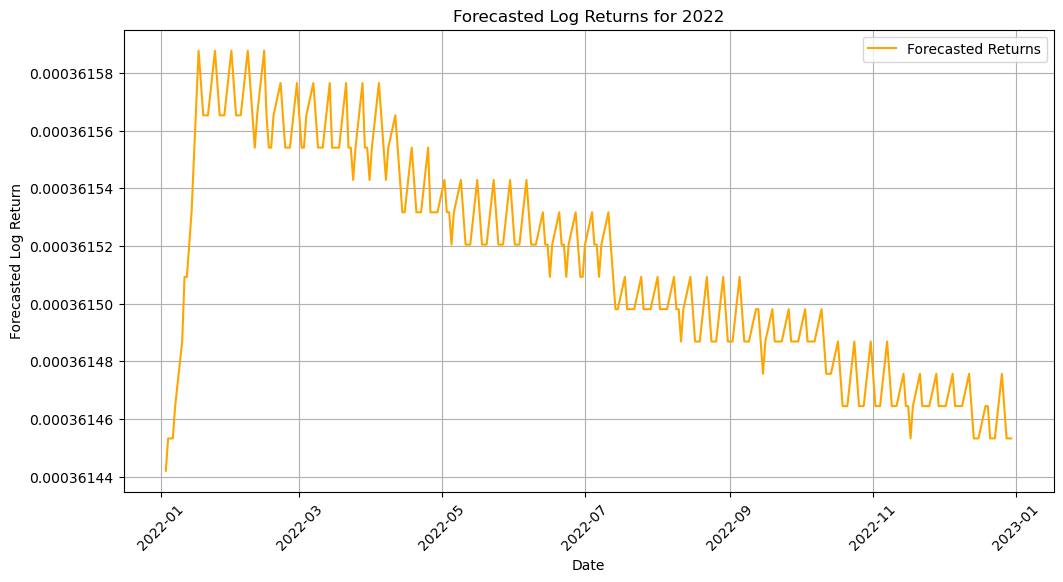

In [14]:
tickers4 = ['XSD']  # Batch 2
results = run_workflow(tickers4)

Processing IYW...


[*********************100%***********************]  1 of 1 completed


(3786, 9)
(1624, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.024409731675583402), ('units', 48)])
Computation Time: 229.36 seconds
Train RMSE: 0.0180, Train MAE: 0.0121, Train MASE : 0.6962 
Test RMSE: 0.0148, Test MAE: 0.0098, Test MASE: 0.6752 
(3786, 9)
(1624, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000434
2022-01-04               0.000438
2022-01-05               0.000437
2022-01-06               0.000437
2022-01-07               0.000437
2022-01-10               0.000436
2022-01-11               0.000438
2022-01-12               0.000437
2022-01-13               0.000437
2022-01-14               0.000437
2022-01-17               0.000436
2022-01-18               0.000437
2022-01-19               0.000437
2022-01-20               0.000437
2022-01-21               0.000436
2022-01-24               0.000436
2022-01-25               0.000437
2

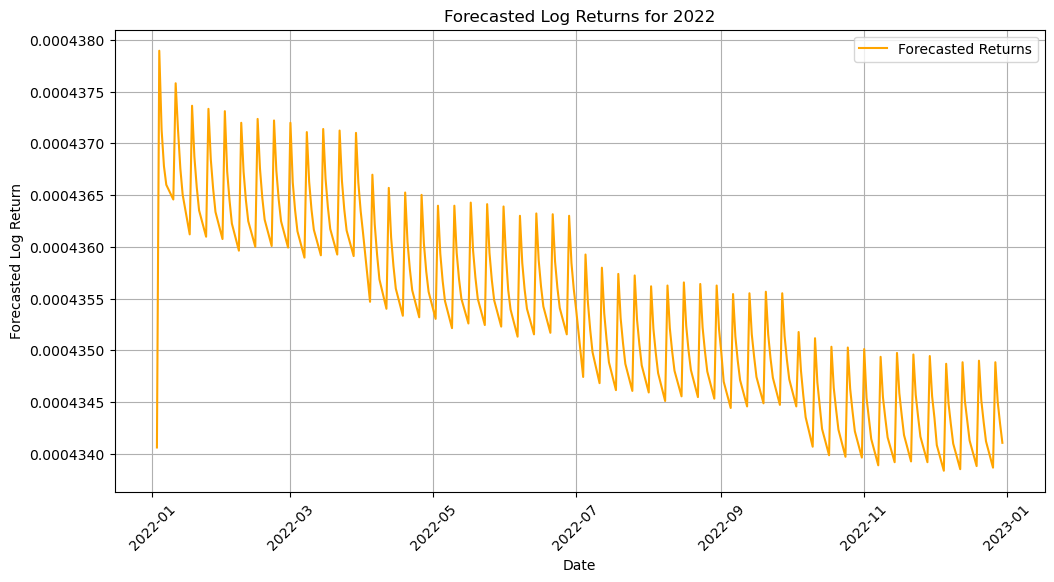

In [15]:
tickers5 = ['IYW']  # Batch 2
results = run_workflow(tickers5)

Processing XLK...


[*********************100%***********************]  1 of 1 completed


(3854, 9)
(1652, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.024409731675583402), ('units', 48)])
Computation Time: 249.81 seconds
Train RMSE: 0.0169, Train MAE: 0.0114, Train MASE : 0.6888 
Test RMSE: 0.0145, Test MAE: 0.0094, Test MASE: 0.6645 
(3854, 9)
(1652, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000089
2022-01-04               0.000090
2022-01-05               0.000090
2022-01-06               0.000090
2022-01-07               0.000090
2022-01-10               0.000090
2022-01-11               0.000090
2022-01-12               0.000090
2022-01-13               0.000090
2022-01-14               0.000090
2022-01-17               0.000089
2022-01-18               0.000090
2022-01-19               0.000090
2022-01-20               0.000090
2022-01-21               0.000090
2022-01-24               0.000089
2022-01-25               0.000090
2

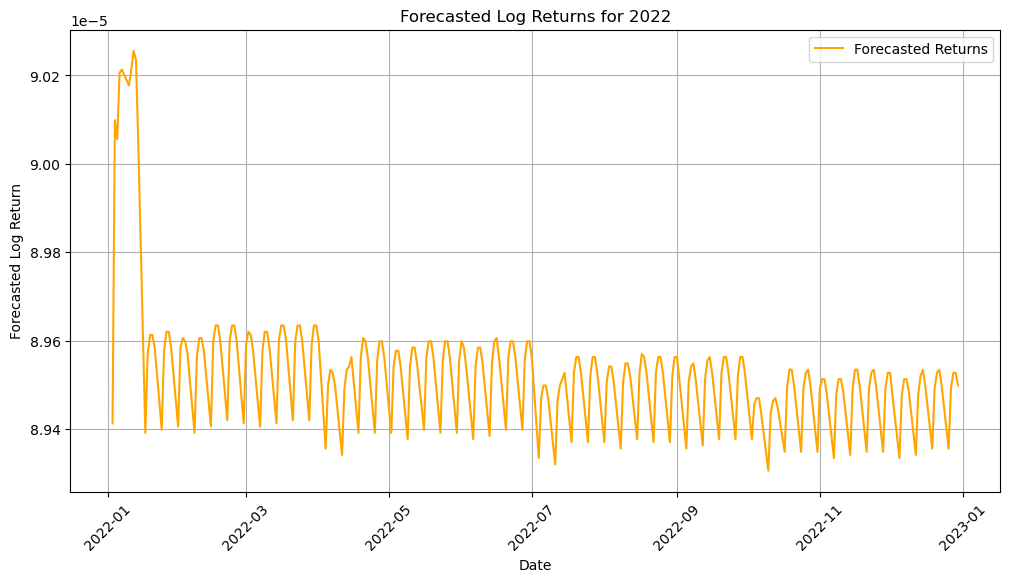

In [16]:
tickers6 = ['XLK']  # Batch 2
results = run_workflow(tickers6)

Processing VGT...


[*********************100%***********************]  1 of 1 completed


(3138, 9)
(1345, 9)
Best Model Parameters: OrderedDict([('dropout', 0.30145212290189727), ('learning_rate', 0.016144853360713744), ('units', 103)])
Computation Time: 199.09 seconds
Train RMSE: 0.0131, Train MAE: 0.0092, Train MASE : 0.6894 
Test RMSE: 0.0150, Test MAE: 0.0098, Test MASE: 0.6648 
(3138, 9)
(1345, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000910
2022-01-04               0.000961
2022-01-05               0.000979
2022-01-06               0.000998
2022-01-07               0.001005
2022-01-10               0.001008
2022-01-11               0.001008
2022-01-12               0.001011
2022-01-13               0.001012
2022-01-14               0.001000
2022-01-17               0.000969
2022-01-18               0.000974
2022-01-19               0.000979
2022-01-20               0.000981
2022-01-21               0.000977
2022-01-24               0.000970
2022-01-25               0.000975

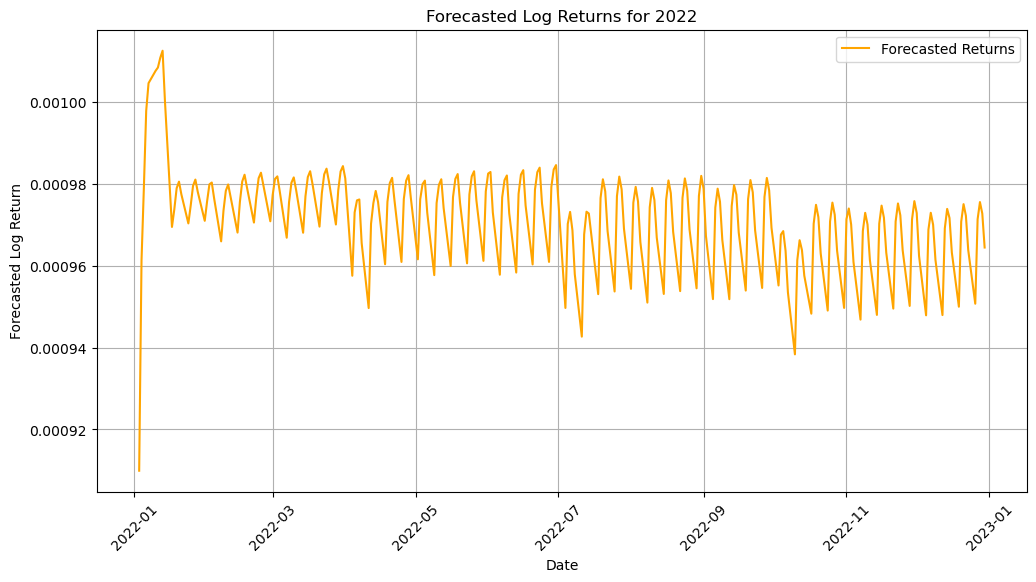

In [17]:
tickers7 = ['VGT']  # Batch 3

results = run_workflow(tickers7)

Processing QQQ...


[*********************100%***********************]  1 of 1 completed


(3854, 9)
(1652, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.024409731675583402), ('units', 48)])
Computation Time: 238.15 seconds
Train RMSE: 0.0183, Train MAE: 0.0122, Train MASE : 0.6876 
Test RMSE: 0.0135, Test MAE: 0.0089, Test MASE: 0.6728 
(3854, 9)
(1652, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.001287
2022-01-04               0.001187
2022-01-05               0.001206
2022-01-06               0.001185
2022-01-07               0.001187
2022-01-10               0.001198
2022-01-11               0.001200
2022-01-12               0.001191
2022-01-13               0.001195
2022-01-14               0.001234
2022-01-17               0.001403
2022-01-18               0.001354
2022-01-19               0.001338
2022-01-20               0.001334
2022-01-21               0.001345
2022-01-24               0.001404
2022-01-25               0.001355
2

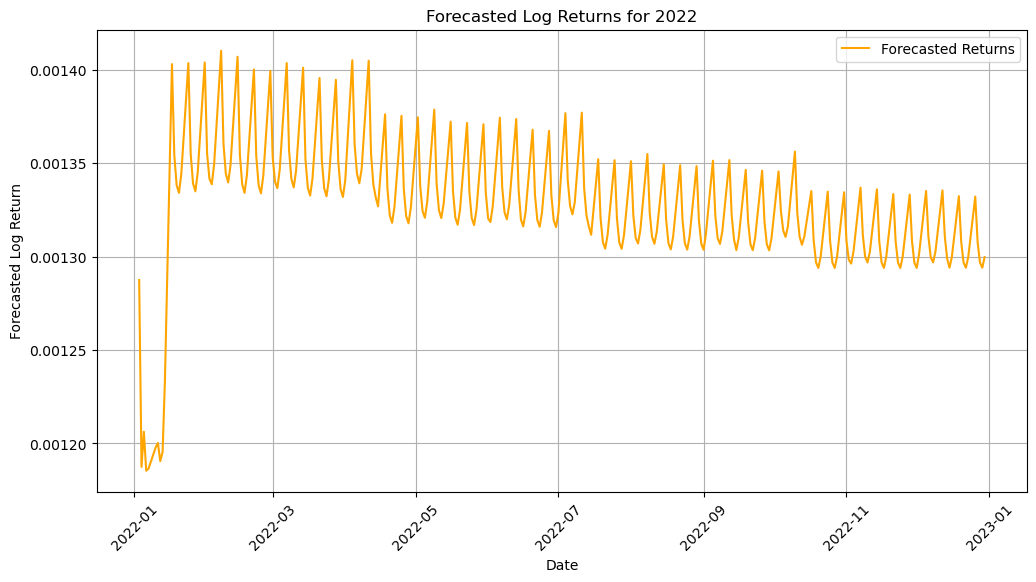

In [18]:
tickers8 = ['QQQ']  # Batch 3

results = run_workflow(tickers8)

Processing IGM...


[*********************100%***********************]  1 of 1 completed


(3641, 9)
(1561, 9)
Best Model Parameters: OrderedDict([('dropout', 0.4779330049204607), ('learning_rate', 0.022754356809600706), ('units', 42)])
Computation Time: 245.49 seconds
Train RMSE: 0.0157, Train MAE: 0.0108, Train MASE : 0.6915 
Test RMSE: 0.0142, Test MAE: 0.0094, Test MASE: 0.6656 
(3641, 9)
(1561, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000620
2022-01-04               0.000618
2022-01-05               0.000619
2022-01-06               0.000618
2022-01-07               0.000618
2022-01-10               0.000618
2022-01-11               0.000618
2022-01-12               0.000618
2022-01-13               0.000618
2022-01-14               0.000619
2022-01-17               0.000622
2022-01-18               0.000621
2022-01-19               0.000621
2022-01-20               0.000621
2022-01-21               0.000621
2022-01-24               0.000622
2022-01-25               0.000621
2

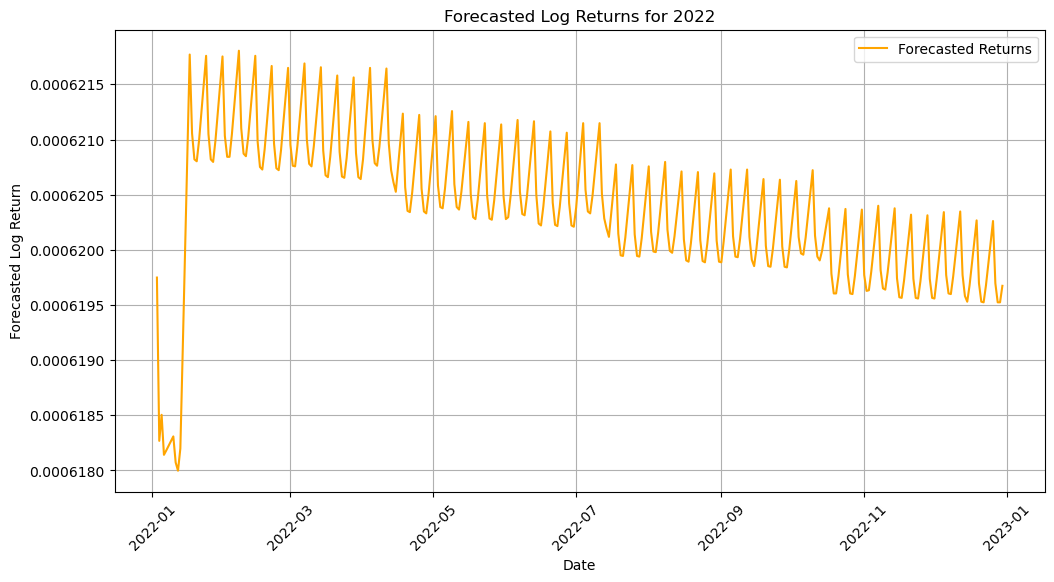

In [19]:
tickers9 = ['IGM']  # Batch 3

results = run_workflow(tickers9)

Processing IXN...


[*********************100%***********************]  1 of 1 completed


(3521, 9)
(1510, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.024409731675583402), ('units', 48)])
Computation Time: 216.27 seconds
Train RMSE: 0.0146, Train MAE: 0.0100, Train MASE : 0.6788 
Test RMSE: 0.0146, Test MAE: 0.0096, Test MASE: 0.6709 
(3521, 9)
(1510, 9)

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2022-01-03               0.000389
2022-01-04               0.000407
2022-01-05               0.000412
2022-01-06               0.000418
2022-01-07               0.000419
2022-01-10               0.000418
2022-01-11               0.000422
2022-01-12               0.000424
2022-01-13               0.000423
2022-01-14               0.000416
2022-01-17               0.000402
2022-01-18               0.000408
2022-01-19               0.000411
2022-01-20               0.000410
2022-01-21               0.000407
2022-01-24               0.000402
2022-01-25               0.000408
2

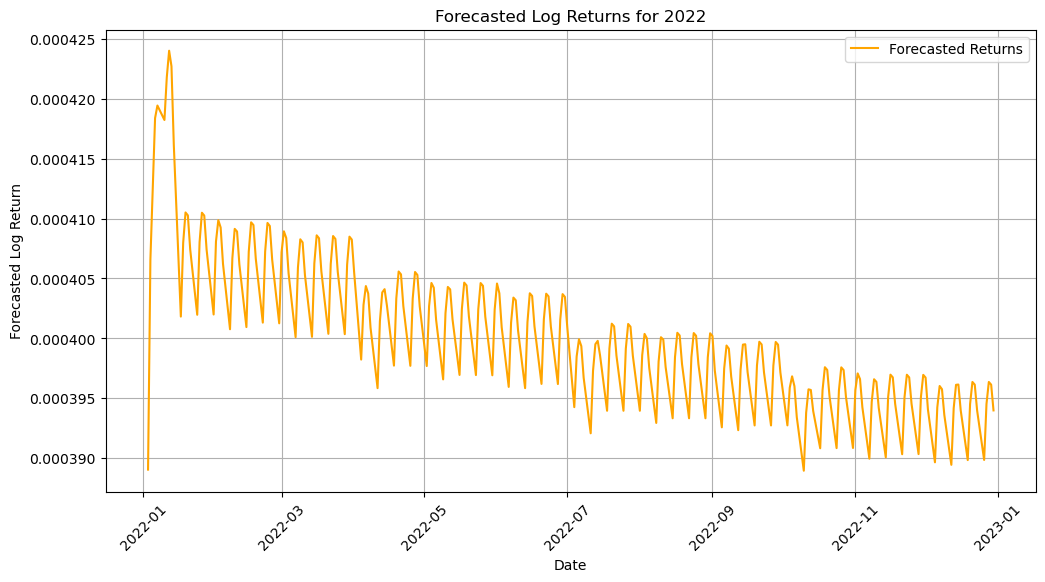

In [20]:
tickers10 = ['IXN']  # Batch 3

results = run_workflow(tickers10)

### Method to define overview of the metrics and plot the same

Overall mean Training MAE: 0.0123
Overall mean Test MAE: 0.0112
Overall mean Training RMSE: 0.0176
Overall mean Test RMSE: 0.0165
Overall mean Training MASE: 0.69
Overall mean Test MASE: 0.67
Total time elapsed to run the model: 2191.22 seconds
Average time consumed by model to train on an ETF: 219.12 seconds


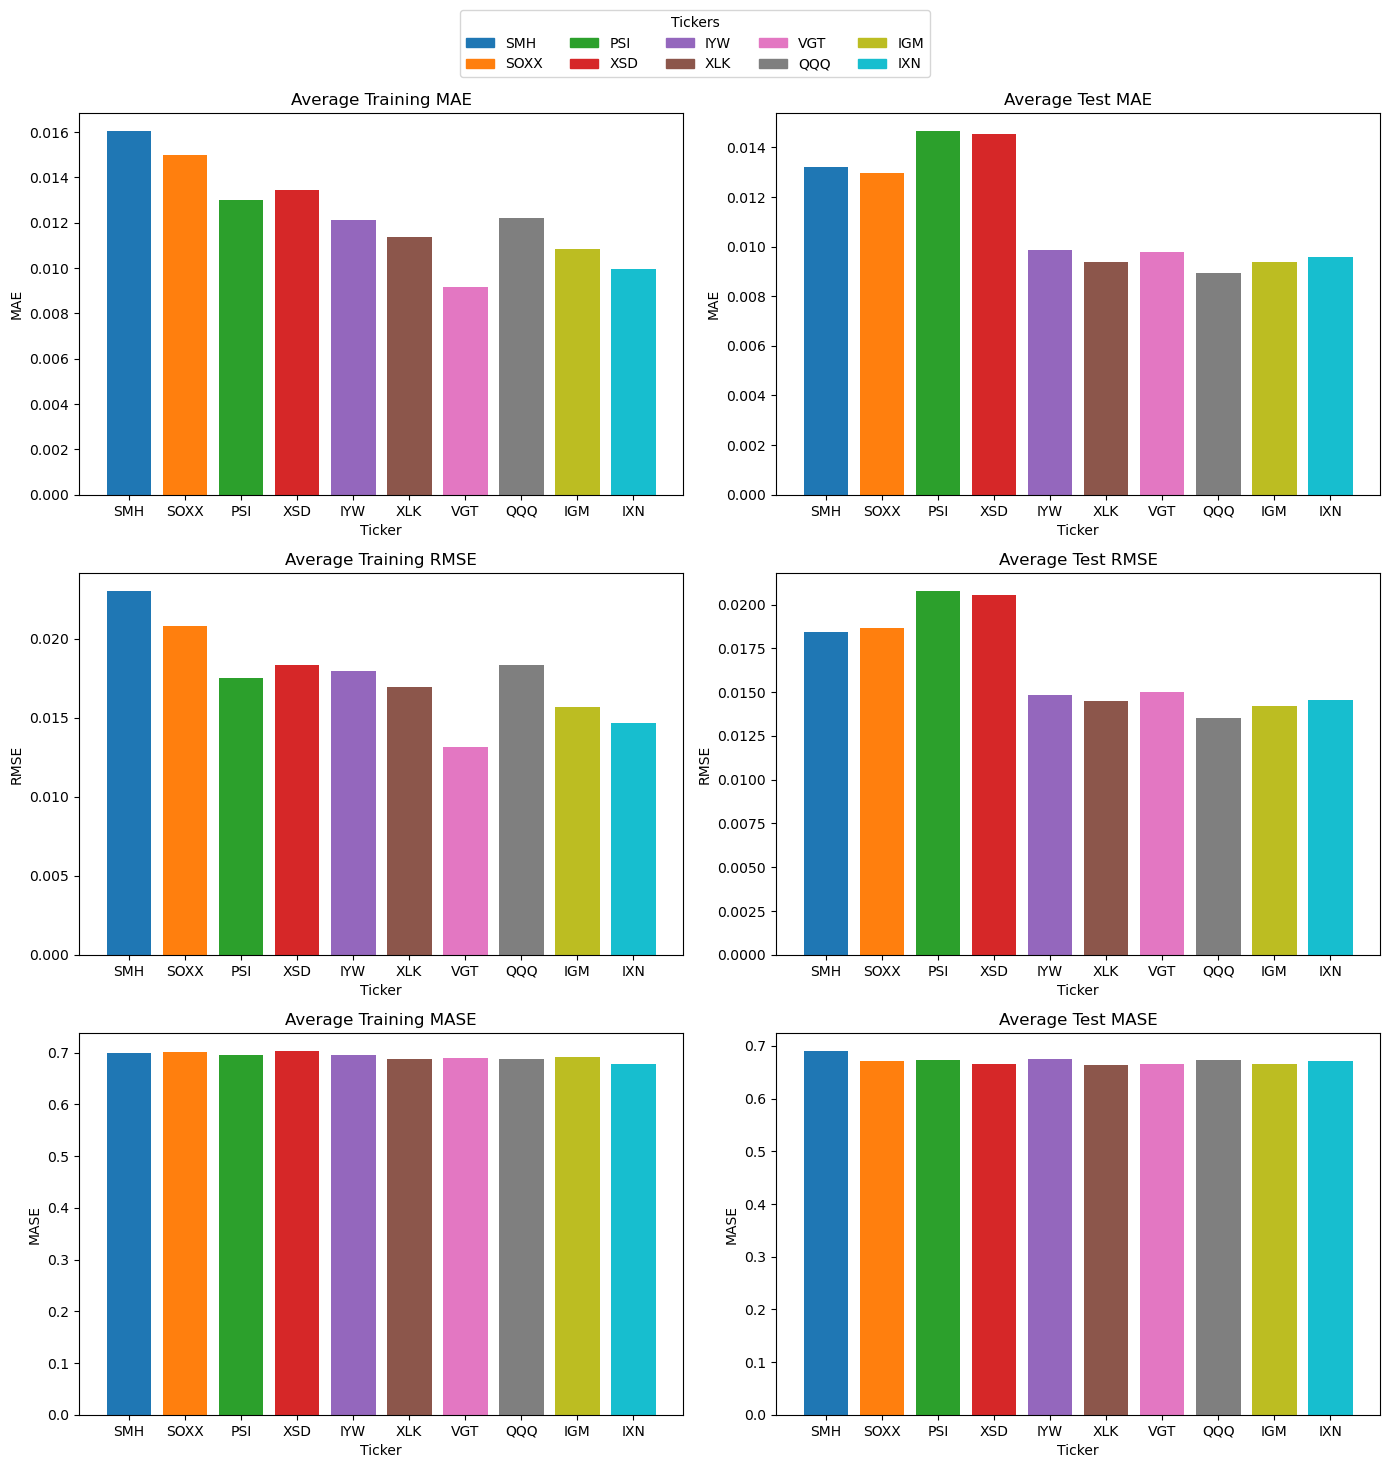

In [26]:
tickers=['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']
def plot_model_metrics(tickers, results):
    """
    Plots model performance metrics (MAE, RMSE, and MASE) for training and test sets.
    
    Parameters:
    - tickers: List of tickers.
    - results: Dictionary containing model metrics for each ticker.
    """
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []
    avg_training_mase = []
    avg_test_mase = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))
        avg_training_mase.append(train_set.get("mase", float('nan')))
        avg_test_mase.append(test_set.get("mase", float('nan')))

        computation_time.append(model_metrics.get("time", float('nan'))) 
    
    # Print global averages
    print(f"Overall mean Training MAE: {mean(avg_training_mae):.4f}")
    print(f"Overall mean Test MAE: {mean(avg_test_mae):.4f}")
    print(f"Overall mean Training RMSE: {mean(avg_training_rmse):.4f}")
    print(f"Overall mean Test RMSE: {mean(avg_test_rmse):.4f}")
    print(f"Overall mean Training MASE: {mean(avg_training_mase):.2f}")
    print(f"Overall mean Test MASE: {mean(avg_test_mase):.2f}")
    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds")
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds")

    # --- 2. Define a color palette ---
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # --- 3. Set up a 3×2 subplot grid ---
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 5: Average Training MASE ---
    ax = axs[2, 0]
    ax.bar(x_positions, avg_training_mase, color=colors[:len(tickers)])
    ax.set_title("Average Training MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 6: Average Test MASE ---
    ax = axs[2, 1]
    ax.bar(x_positions, avg_test_mase, color=colors[:len(tickers)])
    ax.set_title("Average Test MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))
    )

    plt.show()

plot_model_metrics(tickers, results)

### Computation of Perfomance Metrics
- Rachev, Sharpe and Sortino Ratio
- Volatility clustering

In [27]:
def calculate_sharpe_ratio(returns, risk_free_rate_annual=0.1):
    """
    Diagnostic Sharpe Ratio function to print intermediate steps and identify issues.
    
    Parameters:
    - returns (numpy array or list): Array of daily log returns (already partitioned).
    - risk_free_rate_annual (float): Annualized risk-free rate. Default is 3% (0.03).
    
    Returns:
    - sharpe_ratio (float): The Sharpe Ratio.
    """
    # Convert list to numpy array if necessary
    returns = np.array(returns)
    
    # Adjust risk-free rate for daily frequency
    risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / 252) - 1
    
    # Calculate excess returns using daily risk-free rate
    excess_returns = returns - risk_free_rate_daily
    
    # Calculate mean of excess returns
    mean_excess_return = np.mean(excess_returns)
    
    # Calculate unbiased standard deviation using the corrected formula
    k = len(returns)
    mean_return = np.mean(returns)
    
    # Using the alternative unbiased standard deviation formula from the image
    variance = (np.sum(returns**2) / (k - 1)) - (k / (k - 1)) * (mean_return**2)
    std_dev = np.sqrt(variance) if variance > 0 else 0  # Avoid negative sqrt
    
    # **Adjust standard deviation for annualization** (scaling by sqrt(252))
    adjusted_std_dev = std_dev * np.sqrt(252)
    
   
    # Calculate Sharpe Ratio using adjusted standard deviation
    sharpe_ratio = mean_excess_return / adjusted_std_dev if adjusted_std_dev != 0 else 0  # Avoid division by zero
    
    return sharpe_ratio

def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95, epsilon=1e-6):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES) for the left tail (worst-case scenarios)
    if np.any(sorted_returns <= lower_threshold):
        es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    else:
        es = 0  # To handle cases where no returns fall in the left tail
    
    # Step 4: Calculate Expected Gain (EG) for the right tail (best-case scenarios)
    if np.any(sorted_returns >= upper_threshold):
        eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    else:
        eg = 0  # To handle cases where no returns fall in the right tail
    
    # Step 5: Compute the Rachev Ratio with epsilon to prevent division by zero
    es = abs(es) if es != 0 else epsilon  # Replace zero ES with epsilon
    rachev_ratio = eg / es  # No need for abs(es) since zero is replaced with epsilon
    
    return rachev_ratio


def calculate_volatility_clustering(returns, lag=1):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    
    # Handle empty input case
    if len(returns) == 0 or len(returns) <= lag:
        return None  # Return None if not enough data points

    abs_returns = np.abs(returns)  # Use absolute returns as per formula
    
     

    # Compute Pearson correlation between |r_t| and |r_{t+lag}|
    correlation_matrix = np.corrcoef(abs_returns[:-lag], abs_returns[lag:])
    clustering = correlation_matrix[0, 1]  # Extract correlation coefficient
    
    if np.isnan(clustering):
        return 0.0 
    return clustering


def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )

    epsilon = 1e-8

    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


### Compute Composite Scores by using SLSQP problem

In [28]:

def calculate_composite_score_optimized(
    forecasted_values, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)
    
    # Metrics in an array
    metrics = np.array([rachev_normalized, sharpe_normalized, sortino_normalized, -volatility_clustering_normalized])
    
    # Objective function: maximize risk-adjusted composite score
    def objective(weights):
        composite_score = np.dot(weights, metrics)  # Weighted sum
        risk = np.std(metrics * weights)  # Risk adjustment
        return -composite_score / (risk + epsilon)  # Negative for minimization
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: Each weight between 0 and 1
    bounds = [(0, 1) for _ in range(len(metrics))]
    
    # Initial equal weighting
    initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
    
    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    # Compute final optimized composite score
    optimized_score = np.dot(optimized_weights, metrics)
    
    return optimized_score, optimized_weights

def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = score
    
    return composite_scores


### Compute the scores for monthly horizons and plot the scores

In [29]:
def scores_monthly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a monthly basis.
    Return a dictionary of all ETF scores per month.
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per month
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    months = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[month].get(ticker, None) for month in months] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(20, 8))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(months, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(months)), labels=months[::1], rotation=45)

    plt.title("Composite Scores for Tickers Over Months")
    plt.xlabel("Months (1-month intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_monthly(results, return_scores=False)



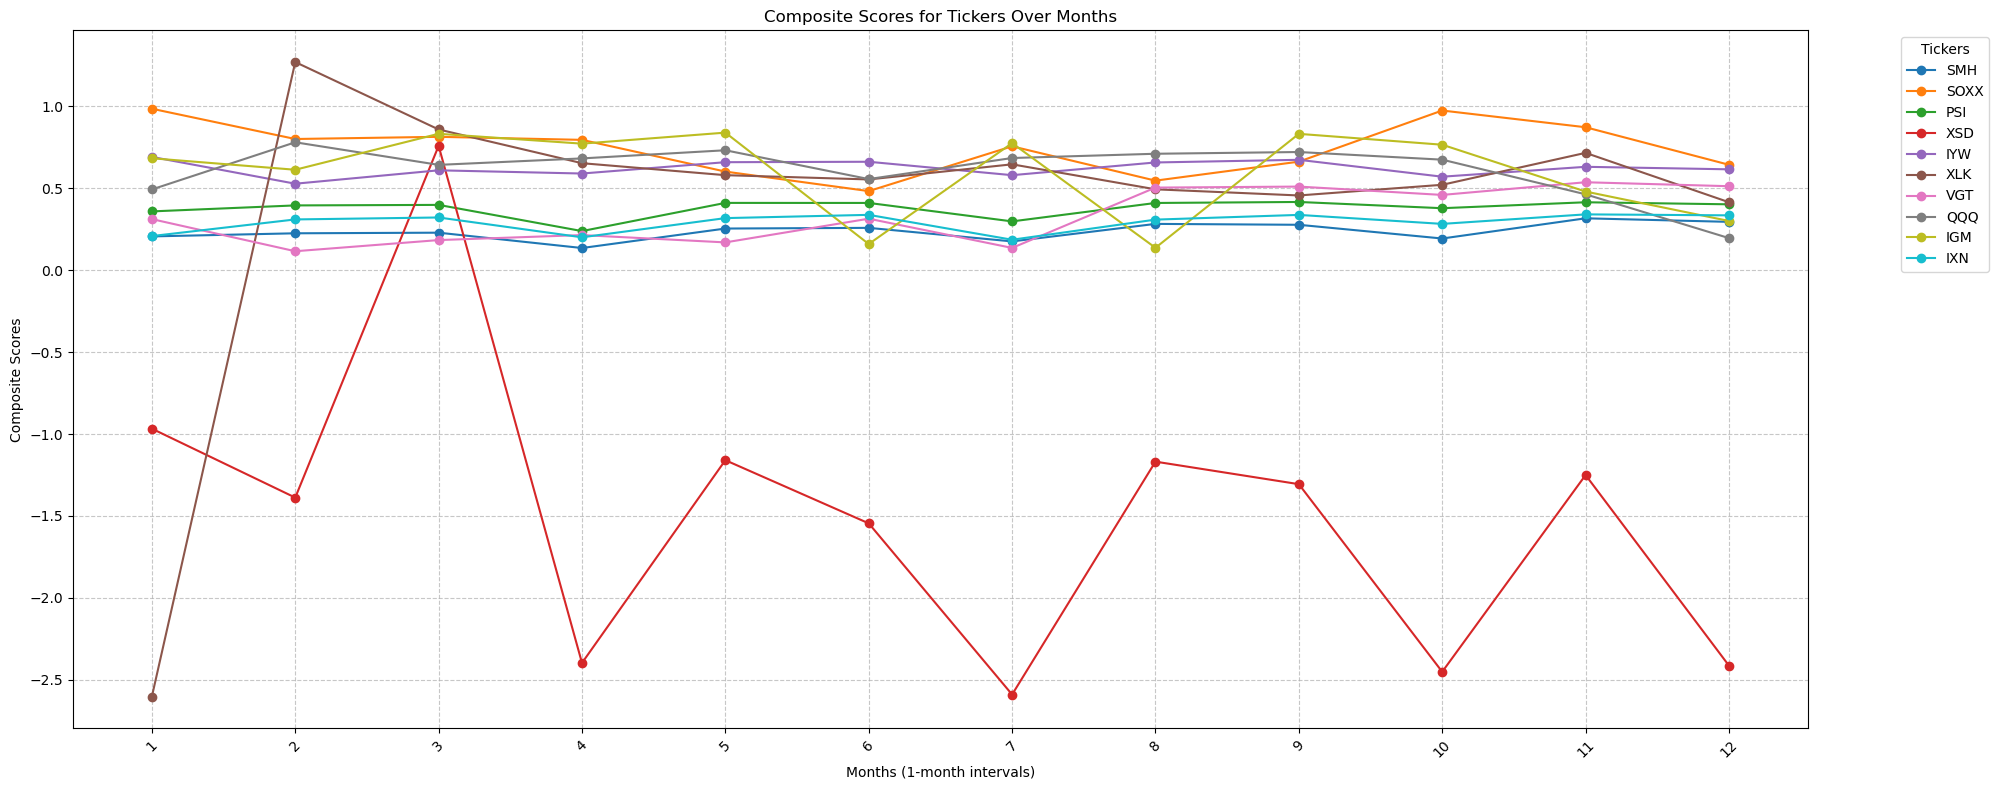

In [30]:
plot_composite_scores(scores, tickers)


### Methods for portfolio optimization of monthly horizon

In [31]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}


In [32]:


def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, smoothing=False):
    all_scores = portfolio(results, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2022-01-01', '2023-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2023-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2023-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            data.columns = data.columns.get_level_values(0)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


### Portfolio Optimization with and without smoothing enabled

In [33]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.20686848350792442, 'SOXX': 0.9863254228020466, 'PSI': 0.3594908001510447, 'XSD': -0.9670439694196875, 'IYW': 0.6921256207628084, 'XLK': -2.602497936626466, 'VGT': 0.3124413877245516, 'QQQ': 0.4935423366099936, 'IGM': 0.683960240793019, 'IXN': 0.20891230172267064}
Month 2: {'SMH': 0.22584384529167525, 'SOXX': 0.801538182164306, 'PSI': 0.39606499220316715, 'XSD': -1.3878803781668927, 'IYW': 0.5285639241820723, 'XLK': 1.2713157462110238, 'VGT': 0.11632531781167248, 'QQQ': 0.781460867267552, 'IGM': 0.6137511465425567, 'IXN': 0.31047716357516936}
Month 3: {'SMH': 0.22958040335917887, 'SOXX': 0.8148619495599528, 'PSI': 0.3992442530387412, 'XSD': 0.759554353633274, 'IYW': 0.6103621397905575, 'XLK': 0.8598188726460962, 'VGT': 0.18442736967392284, 'QQQ': 0.6436389387048183, 'IGM': 0.8333397204211437, 'IXN': 0.32238356360393045}
Month 4: {'SMH': 0.13596205437276368, 'SOXX': 0.7963176497069427, 'PSI': 0.2393786630688563, 'XSD': -2.3973193893

[*********************100%***********************]  1 of 1 completed

Buy SOXX: 278.36 shares at 179.17.
Buy IYW: 436.49 shares at 114.26.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['SOXX', 'IYW']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['SOXX', 'IGM']
Sell IYW: 436.49 shares at 104.79. Total value: 45624.93
Buy IGM: 687.21 shares at 66.23.
Updated ticker shares after 2022-02-01 to 2022-02-28: {'SOXX': 278.36234161718875, 'IGM': 687.2143863292467}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['SOXX', 'IGM']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['SOXX', 'IGM']
Updated ticker shares after 2022-03-01 to 2022-03-31: {'SOXX': 278.36234161718875, 'IGM': 687.2143863292467}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['SOXX', 'IGM']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['SOXX', 'IGM']
Updated ticker shares after 2022-04-01 to 2022-04-30: {'SOXX': 278.36234161718875, 'IGM': 687.2143863292467}
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['SOXX', 'IGM']
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['SOXX', 'IGM']
Updated ticker shares after 2022-05-01 to 2022-05-31: {'SO


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 62291.00


In [34]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.20686848350792442, 'SOXX': 0.9863254228020466, 'PSI': 0.3594908001510447, 'XSD': -0.9670439694196875, 'IYW': 0.6921256207628084, 'XLK': -2.602497936626466, 'VGT': 0.3124413877245516, 'QQQ': 0.4935423366099936, 'IGM': 0.683960240793019, 'IXN': 0.20891230172267064}
Month 2: {'SMH': 0.22584384529167525, 'SOXX': 0.801538182164306, 'PSI': 0.39606499220316715, 'XSD': -1.3878803781668927, 'IYW': 0.5285639241820723, 'XLK': 1.2713157462110238, 'VGT': 0.11632531781167248, 'QQQ': 0.781460867267552, 'IGM': 0.6137511465425567, 'IXN': 0.31047716357516936}
Month 3: {'SMH': 0.22958040335917887, 'SOXX': 0.8148619495599528, 'PSI': 0.3992442530387412, 'XSD': 0.759554353633274, 'IYW': 0.6103621397905575, 'XLK': 0.8598188726460962, 'VGT': 0.18442736967392284, 'QQQ': 0.6436389387048183, 'IGM': 0.8333397204211437, 'IXN': 0.32238356360393045}
Month 4: {'SMH': 0.13596205437276368, 'SOXX': 0.7963176497069427, 'PSI': 0.2393786630688563, 'XSD': -2.3973193893

[*********************100%***********************]  1 of 1 completed

Buy SOXX: 278.36 shares at 179.17.
Buy IYW: 436.49 shares at 114.26.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['SOXX', 'IYW']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['XLK', 'SOXX']
Sell IYW: 436.49 shares at 104.79. Total value: 45624.93
Buy XLK: 287.93 shares at 158.06.
Updated ticker shares after 2022-02-01 to 2022-02-28: {'SOXX': 278.36234161718875, 'XLK': 287.92611326853626}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['XLK', 'SOXX']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['XLK', 'IGM']
Sell SOXX: 278.36 shares at 148.03. Total value: 41103.61
Buy IGM: 670.92 shares at 61.11.
Updated ticker shares after 2022-03-01 to 2022-03-31: {'XLK': 287.92611326853626, 'IGM': 670.9204721979479}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['XLK', 'IGM']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['SOXX', 'IGM']
Sell XLK: 287.93 shares at 154.52. Total value: 44380.28
Buy SOXX: 293.90 shares at 150.63.
Updated ticker shares after 2022-04-01 to 2022-04-30: {'IGM': 670.9204721979479, 'SOXX': 293.895713


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 67347.48


### Compute the scores for weekly horizons and plot the scores

In [35]:

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 53):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results
###
def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }

        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = score
    
    return composite_scores


In [36]:
def scores_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week
import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    weeks = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[week].get(ticker, None) for week in weeks] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(30, 14))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(weeks, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(weeks), 4), labels=weeks[::4], rotation=45)

    plt.title("Composite Scoares for Tickers Over Weeks")
    plt.xlabel("Weeks (4-week intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_weekly(results,return_scores=False)



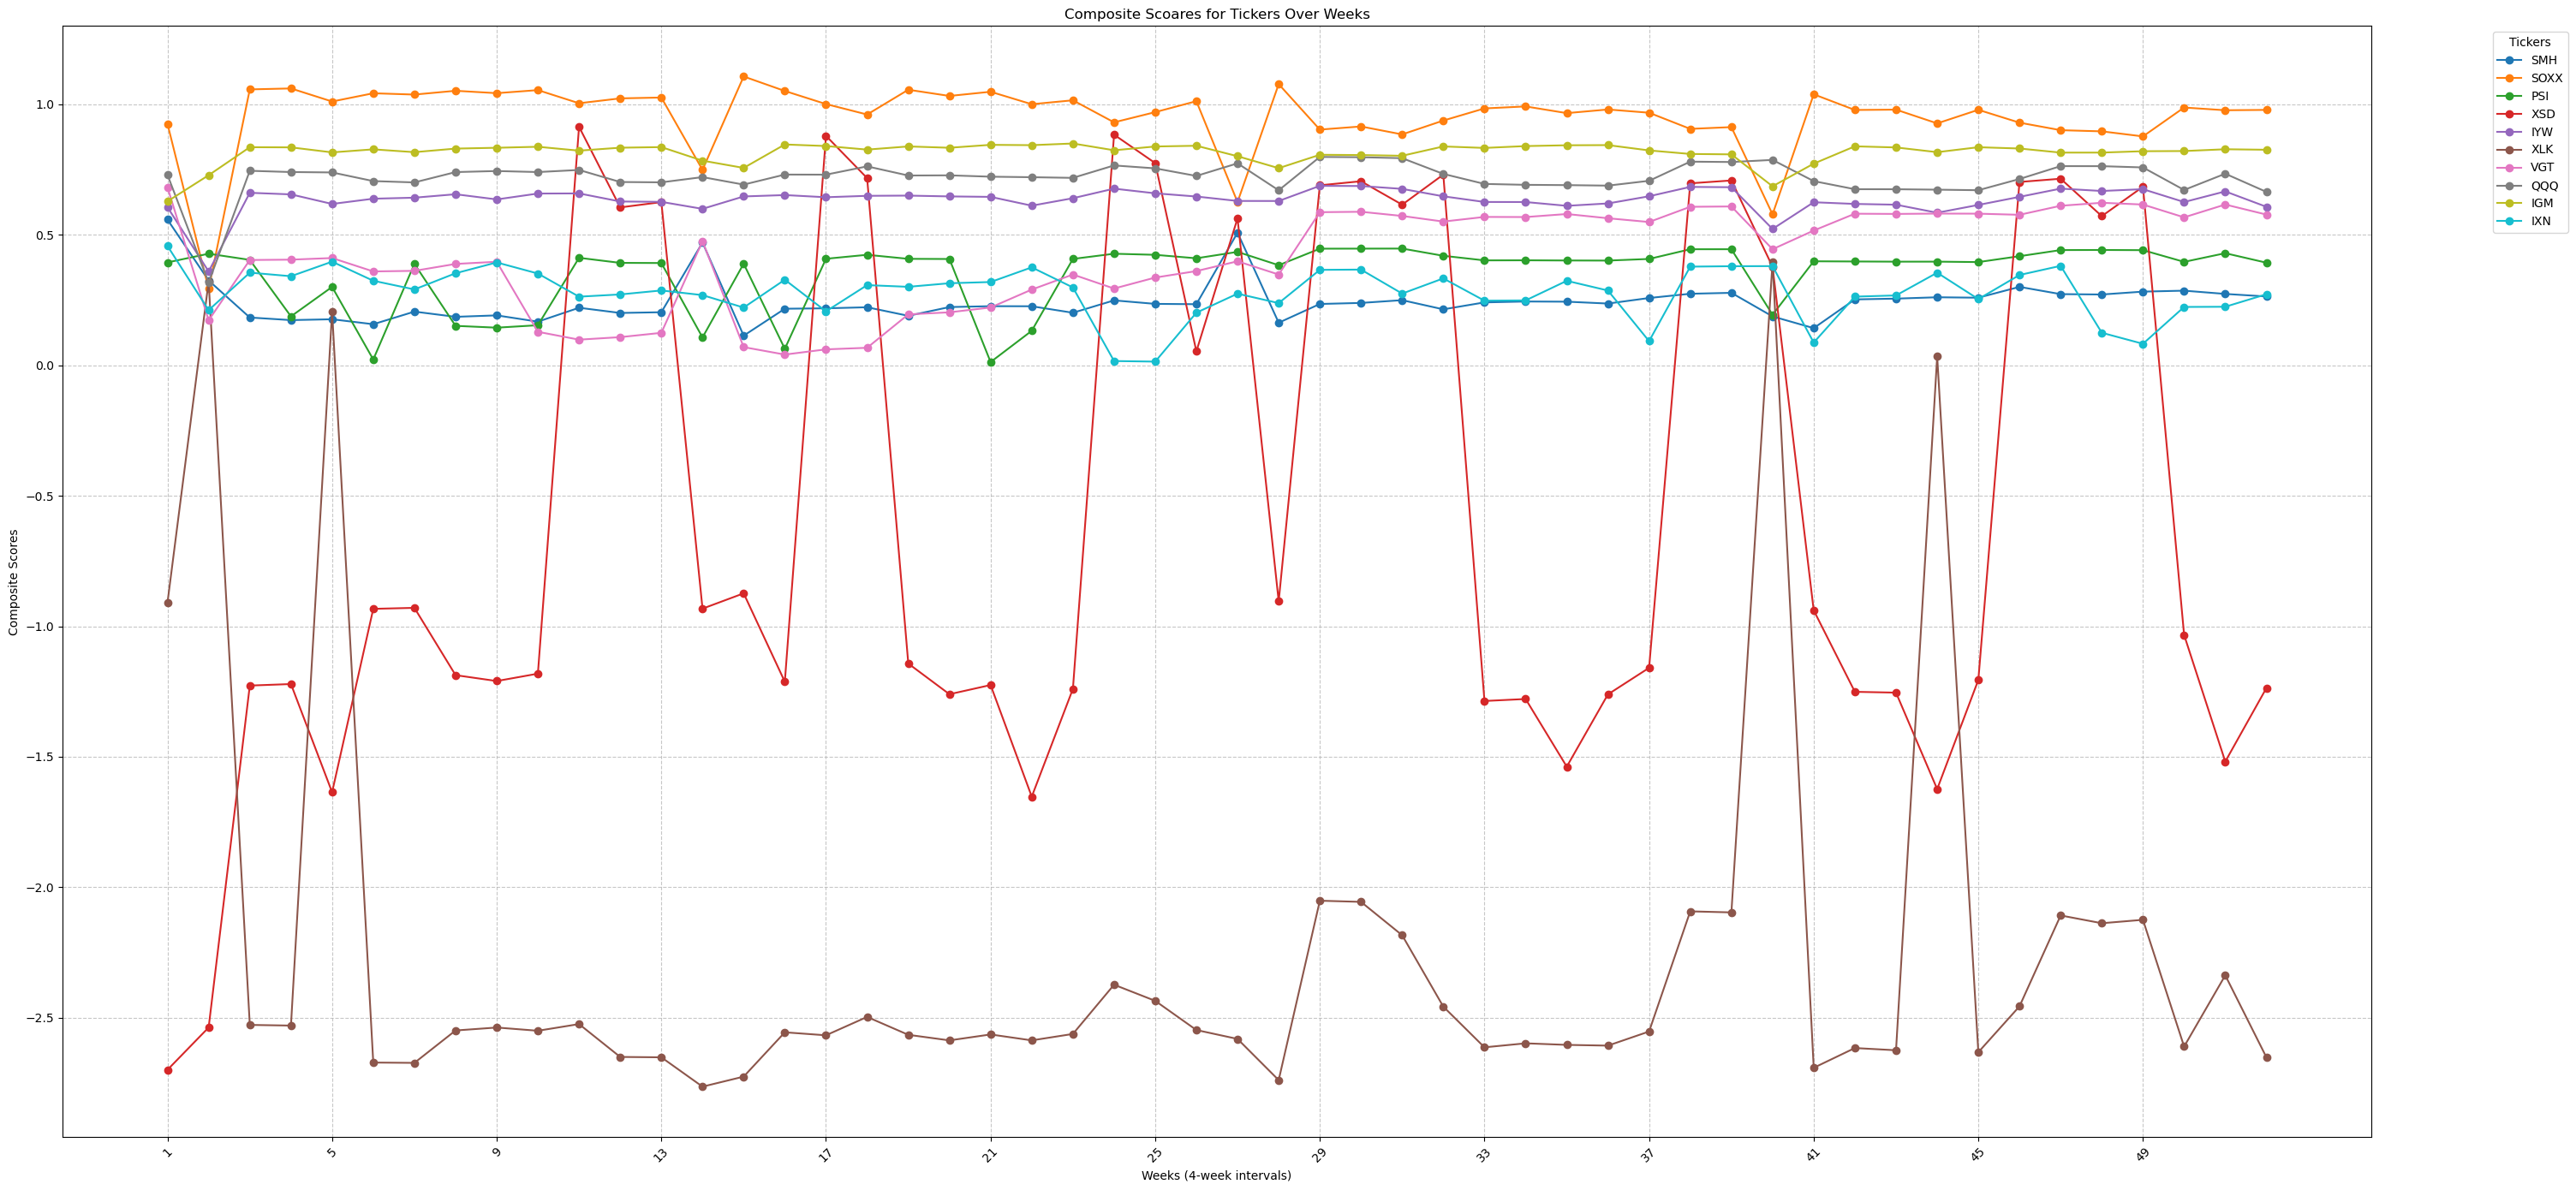

In [37]:
plot_composite_scores(scores, tickers)

### Compute the scores for weekly horizons and plot the scores

In [38]:

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [39]:


def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2022-01-01', '2022-12-31')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2023.
    first_trading_day_53w = '2023-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2023-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            data.columns = data.columns.get_level_values(0)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


### Methods for portfolio optimization of weekly horizon

In [40]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.5584276506676157, 'SOXX': 0.9254037443435311, 'PSI': 0.39434666071530206, 'XSD': -2.699320412498826, 'IYW': 0.6060261279642175, 'XLK': -0.9093648995053759, 'VGT': 0.6820588371707321, 'QQQ': 0.7298685444791695, 'IGM': 0.6283894457666155, 'IXN': 0.45732196558827026}
Week 2: {'SMH': 0.3249874406656035, 'SOXX': 0.29275350179242293, 'PSI': 0.42766076229076266, 'XSD': -2.5372008497453393, 'IYW': 0.35961873295401503, 'XLK': 0.321988977751323, 'VGT': 0.1725512977326519, 'QQQ': 0.3174033120576218, 'IGM': 0.7284204911425638, 'IXN': 0.21133259809123492}
Week 3: {'SMH': 0.18323339651802742, 'SOXX': 1.0572778234351043, 'PSI': 0.40406955402522776, 'XSD': -1.2270597233290392, 'IYW': 0.6610826129274013, 'XLK': -2.527318493309155, 'VGT': 0.4035635061671638, 'QQQ': 0.7454048472752635, 'IGM': 0.8357475069450693, 'IXN': 0.35515347634685673}
Week 4: {'SMH': 0.1732894916708191, 'SOXX': 1.0609425769785696, 'PSI': 0.18751831310748995, 'XSD': -1.2212218733

Buy SOXX: 278.36 shares at 179.17.
Buy QQQ: 126.88 shares at 393.08.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['SOXX', 'QQQ']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['SOXX', 'QQQ']
Updated ticker shares after 2022-01-08 to 2022-01-14: {'SOXX': 278.36227049923264, 'QQQ': 126.88265157463213}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['SOXX', 'QQQ']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'QQQ']
Updated ticker shares after 2022-01-15 to 2022-01-21: {'SOXX': 278.36227049923264, 'QQQ': 126.88265157463213}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'QQQ']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['SOXX', 'QQQ']
Updated ticker shares after 2022-01-22 to 2022-01-28: {'SOXX': 278.36227049923264, 'QQQ': 126.88265157463213}
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['SOXX', 'QQQ']
Top 2 ETFs for 2022-01-29 to 2022-02-04: ['SOXX', 'QQQ']
Updated ticker shares after 2022-01-29 to 2022-02-04: {'SOXX': 278.36227049923264, 'QQQ': 126.88265157463213}
Top 2 ETFs for 2022-01-29 to 2022-0

Final Portfolio Value: 63213.46


In [41]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.5584276506676157, 'SOXX': 0.9254037443435311, 'PSI': 0.39434666071530206, 'XSD': -2.699320412498826, 'IYW': 0.6060261279642175, 'XLK': -0.9093648995053759, 'VGT': 0.6820588371707321, 'QQQ': 0.7298685444791695, 'IGM': 0.6283894457666155, 'IXN': 0.45732196558827026}
Week 2: {'SMH': 0.3249874406656035, 'SOXX': 0.29275350179242293, 'PSI': 0.42766076229076266, 'XSD': -2.5372008497453393, 'IYW': 0.35961873295401503, 'XLK': 0.321988977751323, 'VGT': 0.1725512977326519, 'QQQ': 0.3174033120576218, 'IGM': 0.7284204911425638, 'IXN': 0.21133259809123492}
Week 3: {'SMH': 0.18323339651802742, 'SOXX': 1.0572778234351043, 'PSI': 0.40406955402522776, 'XSD': -1.2270597233290392, 'IYW': 0.6610826129274013, 'XLK': -2.527318493309155, 'VGT': 0.4035635061671638, 'QQQ': 0.7454048472752635, 'IGM': 0.8357475069450693, 'IXN': 0.35515347634685673}
Week 4: {'SMH': 0.1732894916708191, 'SOXX': 1.0609425769785696, 'PSI': 0.18751831310748995, 'XSD': -1.2212218733

Buy SOXX: 278.36 shares at 179.17.
Buy QQQ: 126.88 shares at 393.08.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['SOXX', 'QQQ']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IGM', 'PSI']
Sell QQQ: 126.88 shares at 371.97. Total value: 47078.75
Sell SOXX: 278.36 shares at 168.91. Total value: 46901.66
Buy IGM: 683.41 shares at 68.72.
Buy PSI: 993.31 shares at 47.10.
Updated ticker shares after 2022-01-08 to 2022-01-14: {'IGM': 683.407546026451, 'PSI': 993.3060359589001}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IGM', 'PSI']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'IGM']
Sell PSI: 993.31 shares at 45.64. Total value: 45221.64
Buy SOXX: 272.37 shares at 165.61.
Updated ticker shares after 2022-01-15 to 2022-01-21: {'IGM': 683.407546026451, 'SOXX': 272.3739636304524}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['SOXX', 'IGM']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['SOXX', 'IGM']
Updated ticker shares after 2022-01-22 to 2022-01-28: {'SOXX': 272.3739636304524, 'IGM': 683.407546026451}

Final Portfolio Value: 62010.22
